In [1]:
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor as RFR, ExtraTreesRegressor as ETR, GradientBoostingRegressor as GBR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import PassiveAggressiveRegressor as PAR
from sklearn.kernel_ridge import KernelRidge as KR
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

colTypesDict = {"MSSubClass":'category',"MSZoning":'category',"Street":'category',"Alley":'category',
                "LotShape":'category',"LandContour":'category',"Utilities":'category',
                "LotConfig":'category',"LandSlope":'category',"Neighborhood":'category',"Condition1":'category',
                "Condition2":'category',"BldgType":'category',"HouseStyle":'category',"RoofStyle":'category',
                "RoofMatl":'category',"Exterior1st":'category',"Exterior2nd":'category',"MasVnrType":'category',
                "ExterQual":'category',"ExterCond":'category',"Foundation":'category',
                "BsmtQual":'category',"BsmtCond":'category',"BsmtExposure":'category',"BsmtFinType1":'category',
                "BsmtFinType2":'category',"Heating":'category',"HeatingQC":'category',"CentralAir":'category',
                "Electrical":'category',"KitchenQual":'category',"Functional":'category',"FireplaceQu":'category',
                "GarageType":'category',"GarageFinish":'category',
                "GarageQual":'category',"GarageCond":'category',"PavedDrive":'category',
                "PoolQC":'category',"Fence":'category',"MiscFeature":'category',
                "SaleType":'category',"SaleCondition":'category'}

# # LOAD THE PROVIDED TRAINING DATA
# train = pd.read_csv('data/train.csv',delimiter=',',header=0,dtype=colTypesDict,na_values=["NA"])
# test = pd.read_csv('data/test.csv',delimiter=',',header=0)

train = pd.read_csv('data/train_fe.csv',delimiter=',',header=0,dtype=colTypesDict,na_values=["NA"])
train_labels = train["SalePrice"].copy()
train_labels = np.log(train["SalePrice"])
train = train.drop( ["SalePrice"], axis=1 )
train = pd.get_dummies(train, columns = train.select_dtypes(include=['category']).columns)
train_split, dev, train_split_labels, dev_labels = train_test_split(train,train_labels, test_size = .2)
test = pd.read_csv('data/test_fe.csv',delimiter=',',header=0)
test = pd.get_dummies(test, columns = test.select_dtypes(include=['category']).columns)

def simple_rmse(model, X, Y):
    y_pred = model.predict(X)
    rmse = -np.sqrt(mean_squared_error(y_pred, Y))
    return rmse

def rmse_cv(model, X_train, y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def plot_it(model):
    model.fit(train_split, train_split_labels)
    preds = model.predict(dev)
    
    deltas = preds-dev_labels
    print "mean: %3.4f" %np.mean(deltas)
    print "standard deviation: %3.4f" %np.std(deltas)
    
    plt.scatter(dev_labels,preds)
    plt.xlim((10,14.0))
    plt.ylim((10,14.0))
    plt.plot(range(10,15), range(10,15));
    
def plot_rfe(model):
    scores = []
    for i in range(50):
        rfe = RFE(model, i+1)
        rfe.fit(train_split,train_split_labels)
        scores.append(rfe.score(dev,dev_labels))
    
    plt.scatter(range(1,51),scores)
    plt.show()
    
def plot_pca(model, n):
    scores = []
    pca = PCA(n)
    pca_train = pca.fit_transform(train_split)
    pca_dev = pca.transform(dev)
    for i in range(n):
        model.fit(pca_train[:,0:i+1], train_split_labels)
        scores.append(-simple_rmse(model, pca_dev[:,0:i+1], dev_labels))
    
    plt.scatter(range(1,n+1),scores)
    plt.show()

print train.shape
print test.shape

(1460, 347)
(1460, 347)


In [3]:
rfr_model = RFR() #n_estimators, max_features, max_depth, bootstrap
etr_model = ETR() #n_estimatros, criterion, max_features, max_depth, bootstrap
gbr_model = GBR() #loss, learning_rate, n_estimators, max_depth, max_features, alpha
knr_model = KNR() #n_neighbors, weights
dtr_model = DTR() #max_features, max_depth
lsvr_model = SVR(kernel="linear") #C, epsilon, kernel, degree
psvr_model = SVR(kernel="poly") #C, epsilon, kernel, degree
rsvr_model = SVR(kernel="rbf") #C, epsilon, kernel, degree
gpr_model = GPR() #none
par_model = PAR()
lkr_model = KR(kernel="linear")
pkr_model = KR(kernel="poly")
rkr_model = KR(kernel="rbf")

x = train
y = train_labels


468.868000031
-0.155233963016
{'max_features': 'auto', 'n_estimators': 250}


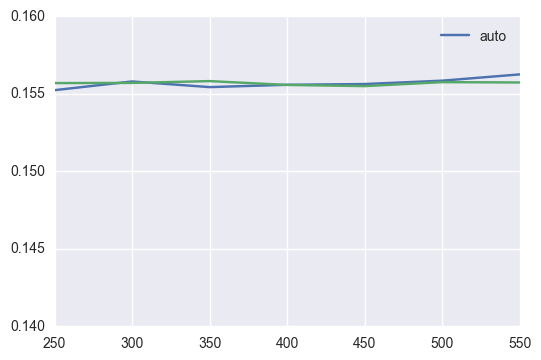

In [29]:
#RandomForestRegressor
est = [250,300,350,400,450,500,550]
feat = ["auto",None]
start = time.time()
rfr_params = {"n_estimators": est,
             "max_features": feat}
gs1 = GridSearchCV(rfr_model, rfr_params, scoring = simple_rmse)
gs1.fit(x,y)
end = time.time()
print end-start
print gs1.best_score_
print gs1.best_params_

for a,val in enumerate(feat):
    plt.plot(est,-gs1.cv_results_['mean_test_score'][len(est)*a:len(est)*(a+1)], label=val)
    plt.legend()
plt.ylim((.14,.16))
plt.show;


mean: -0.0021
standard deviation: 0.1582


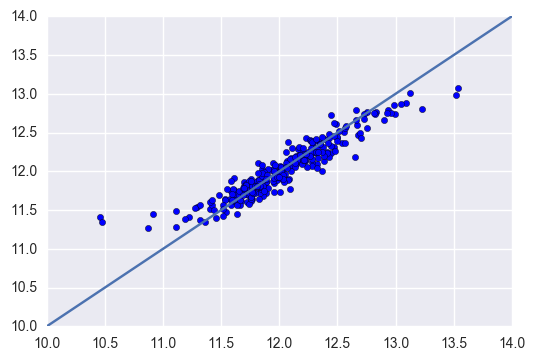

In [30]:
rfr_best = RFR(n_estimators =gs1.best_params_['n_estimators'],max_features =gs1.best_params_['max_features'])
plot_it(rfr_best)

139.873000145
ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
-0.159850877452
{'max_features': 'auto', 'n_estimators': 200, 'bootstrap': True, 'criterion': 'mse'}


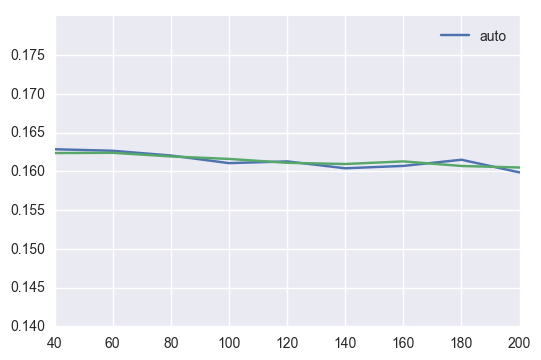

In [31]:
##ExtraTreesRegressor
est = [40,60,80,100,120,140,160,180,200]
feat = ["auto",None]
start = time.time()
etr_params = {"n_estimators": est,
             "max_features": feat,
             "criterion": ["mse"],
             "bootstrap": [True]}
gs2 = GridSearchCV(etr_model, etr_params, scoring = simple_rmse)
gs2.fit(x,y)
end = time.time()
print end-start
print gs2.best_estimator_
print gs2.best_score_
print gs2.best_params_

for a,val in enumerate(feat):
    plt.plot(est,-gs2.cv_results_['mean_test_score'][len(est)*a:len(est)*(a+1)], label=val)
    plt.legend()
plt.ylim((.14,.18))
plt.show;


mean: -0.0078
standard deviation: 0.1599


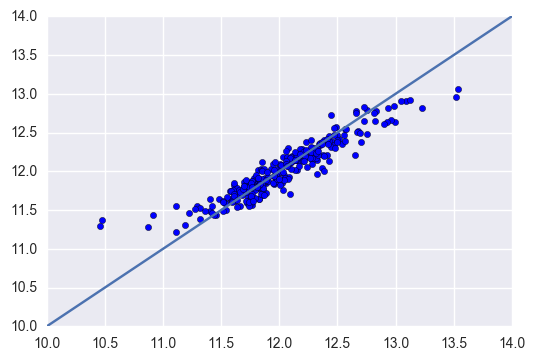

In [32]:
etr_best = ETR(n_estimators =gs2.best_params_['n_estimators'],max_features =gs2.best_params_['max_features'], criterion = "mse", bootstrap = True)
plot_it(etr_best)

371.568000078
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.075, loss='ls', max_depth=2,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.133862762547
{'max_features': 'auto', 'loss': 'ls', 'learning_rate': 0.075, 'n_estimators': 500, 'max_depth': 2}
[-0.14678077 -0.14343919 -0.14072782 -0.13891319 -0.13812297 -0.13771173
 -0.13663246 -0.14030632 -0.13881382 -0.1376172  -0.1369915  -0.13640526
 -0.13614652 -0.13599382 -0.14128722 -0.13929975 -0.13803235 -0.13726546
 -0.1360052  -0.13433319 -0.13386276 -0.13856125 -0.13781717 -0.13828752
 -0.13786915 -0.13722697 -0.13710967 -0.13781096 -0.13974823 -0.13873001
 -0.1381859  -0.13730121 -0.13564414 -0.13596257 -0.13528597 -0.13941674

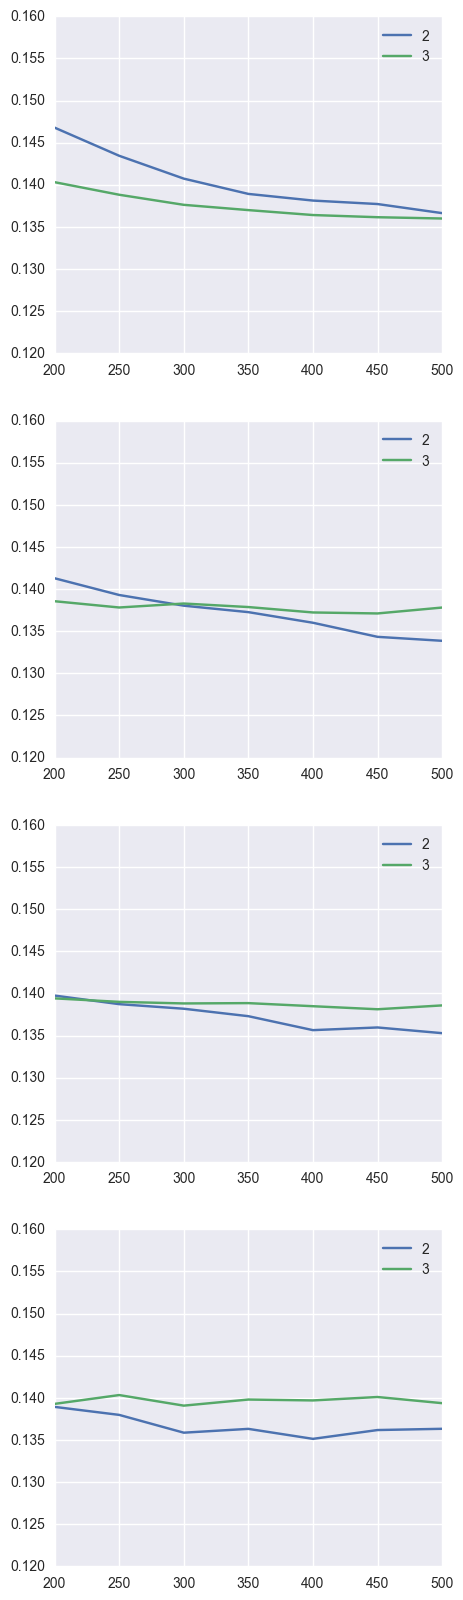

In [33]:
##GradientBoostingRegressor
est = [200,250,300,350,400, 450, 500]
md = [2,3]
lr = [.05, .075, .1, .15]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["ls"]}#,"ls", "lad", "huber"]}
gs3 = GridSearchCV(gbr_model, gbr_params, scoring = simple_rmse)
gs3.fit(x,y)
end = time.time()
print end-start
print gs3.best_estimator_
print gs3.best_score_
print gs3.best_params_
print gs3.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        axarr[b].set_ylim((.12,.16))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;


mean: 0.0022
standard deviation: 0.1231


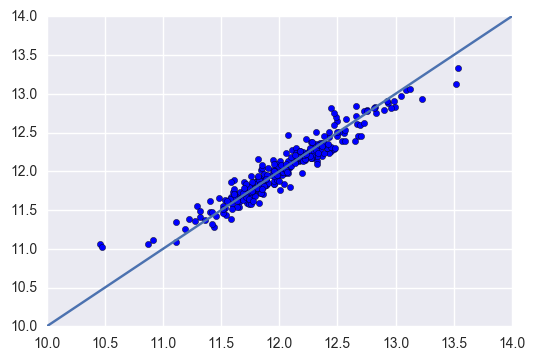

In [34]:
ls_gbr_best = GBR(n_estimators =gs3.best_params_['n_estimators'],max_features =gs3.best_params_['max_features'], max_depth =gs3.best_params_['max_depth'], learning_rate =gs3.best_params_['learning_rate'], loss=gs3.best_params_['loss'])
plot_it(ls_gbr_best)

1113.3269999
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='lad', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.136999484136
{'max_features': 'auto', 'loss': 'lad', 'learning_rate': 0.15, 'n_estimators': 400, 'max_depth': 3}
[-0.15094845 -0.14704245 -0.14521283 -0.14620693 -0.14349256 -0.14373478
 -0.1424102  -0.14690066 -0.14381559 -0.14410493 -0.14079287 -0.14138775
 -0.14189908 -0.13934189 -0.14594399 -0.14317866 -0.14078118 -0.14264547
 -0.14088298 -0.13882817 -0.13856485 -0.14554793 -0.14527778 -0.14343021
 -0.14147458 -0.14106964 -0.14115643 -0.14101921 -0.14559888 -0.14310241
 -0.14059772 -0.14102099 -0.14041519 -0.13704756 -0.13885442 -0.14452863


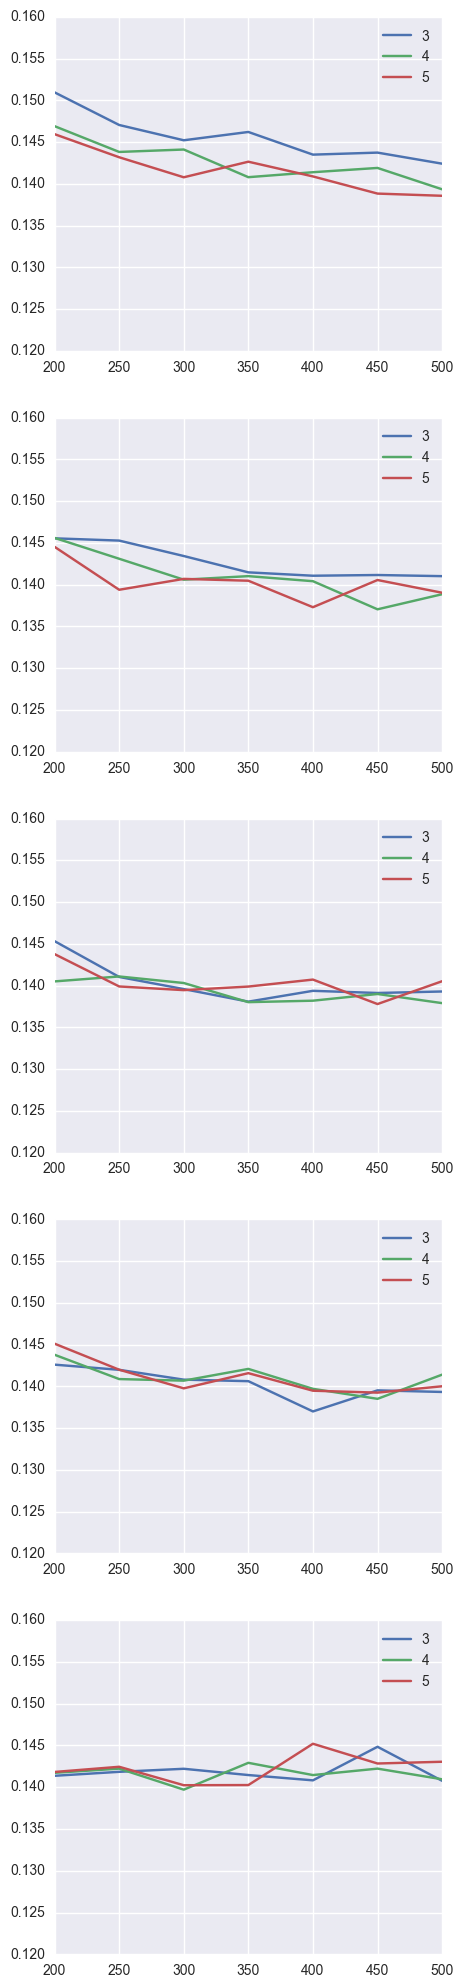

In [35]:
##GradientBoostingRegressor
est = [200,250,300,350,400, 450, 500]
md = [3,4,5]
lr = [.05, .075, .1, .15,.2]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["lad"]}#,"ls", "lad", "huber"]}
gs3b = GridSearchCV(gbr_model, gbr_params, scoring = simple_rmse)
gs3b.fit(x,y)
end = time.time()
print end-start
print gs3b.best_estimator_
print gs3b.best_score_
print gs3b.best_params_
print gs3b.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3b.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        axarr[b].set_ylim((.12,.16))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;


mean: 0.0017
standard deviation: 0.1441


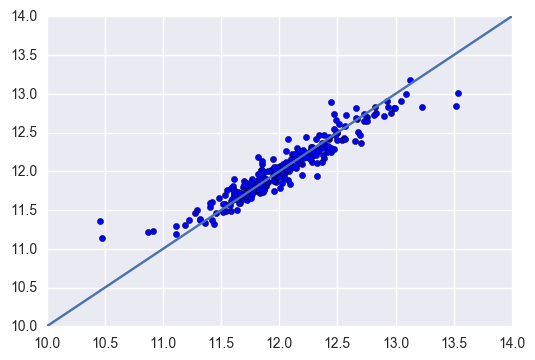

In [36]:
lad_gbr_best = GBR(n_estimators =gs3b.best_params_['n_estimators'],max_features =gs3b.best_params_['max_features'], max_depth =gs3b.best_params_['max_depth'], learning_rate =gs3b.best_params_['learning_rate'], loss=gs3b.best_params_['loss'])
plot_it(lad_gbr_best)

904.318000078
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=2,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
-0.12921539475
{'max_features': 'auto', 'loss': 'huber', 'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 2}
[-0.15672316 -0.1485154  -0.14464247 -0.14189955 -0.13984424 -0.13840216
 -0.13732473 -0.13506029 -0.13353497 -0.14583366 -0.14177489 -0.13952037
 -0.1376946  -0.13644973 -0.13618777 -0.13501738 -0.13503252 -0.13436103
 -0.14117626 -0.13895921 -0.13681897 -0.13560809 -0.13544487 -0.13502709
 -0.13496203 -0.13542205 -0.13448939 -0.14705985 -0.14219645 -0.13871852
 -0.13720912 -0.13333224 -0.13284088 -0.13173879 -0.1318371  -0.1302287

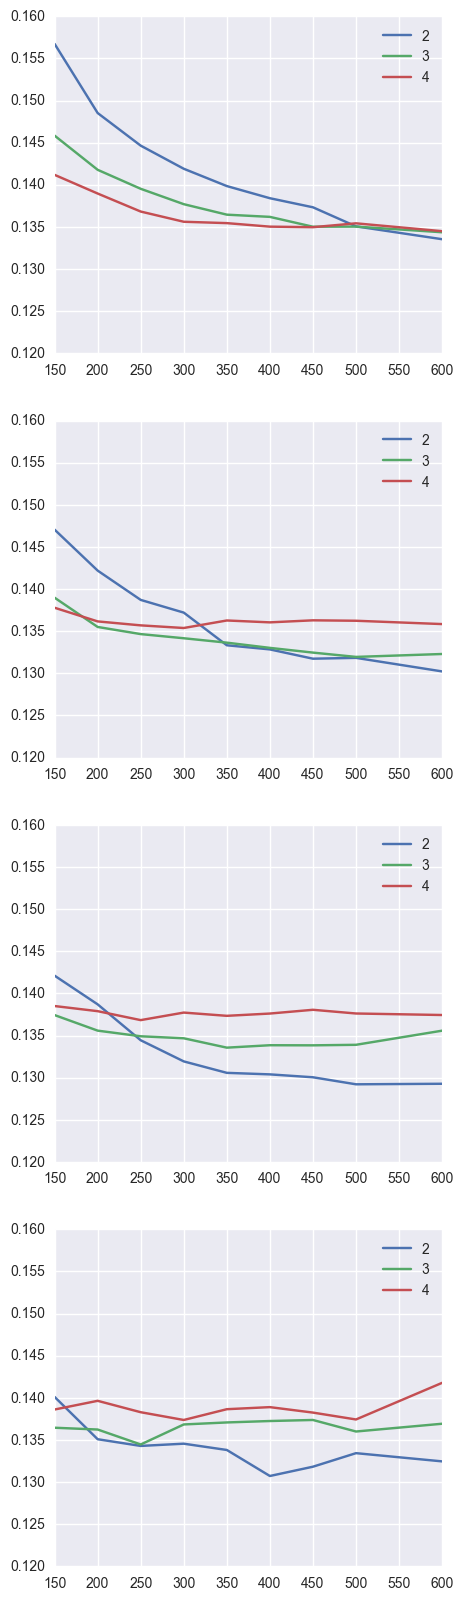

In [78]:
##GradientBoostingRegressor
est = [150,200,250,300,350,400, 450, 500,600]
md = [2,3,4]
lr = [.05, .075, .1, .15]
start = time.time()
gbr_params = {"n_estimators": est,
             "max_features": ["auto"],
             "max_depth": md,
             "learning_rate": lr,
             "loss": ["huber"]}#,"ls", "lad", "huber"]}
gs3c = GridSearchCV(gbr_model, gbr_params, scoring = simple_rmse)
gs3c.fit(x,y)
end = time.time()
print end-start
print gs3c.best_estimator_
print gs3c.best_score_
print gs3c.best_params_
print gs3c.cv_results_['mean_test_score']

f, axarr = plt.subplots(len(lr))
for b,val2 in enumerate(lr):
    for a,val in enumerate(md):
        axarr[b].plot(est,-gs3c.cv_results_['mean_test_score'][(len(est)*a)+(len(est)*len(md))*b:(len(est)*(a+1))+(len(est)*len(md))*b], label=val)
        axarr[b].legend()
        axarr[b].set_ylim((.12,.16))
        
f.set_figheight(5 * len(lr))
f.set_figwidth(5)
f.show;



mean: -0.0004
standard deviation: 0.1215


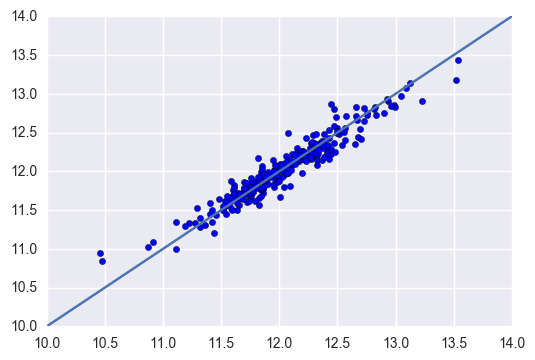

In [38]:
huber_gbr_best = GBR(n_estimators =gs3c.best_params_['n_estimators'],max_features =gs3c.best_params_['max_features'], max_depth =gs3c.best_params_['max_depth'], learning_rate =gs3c.best_params_['learning_rate'], loss=gs3c.best_params_['loss'])
plot_it(huber_gbr_best)

In [16]:
test = x
test.ix[:,"Neighborhood_Blmngtn":"Neighborhood_Veenker"] = x.ix[:,"Neighborhood_Blmngtn":"Neighborhood_Veenker"]*1000
#print test.ix[:,"Neighborhood_Blmngtn":"Neighborhood_Veenker"]

43.2089998722
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
-0.197501840046
{'n_neighbors': 5, 'weights': 'uniform'}


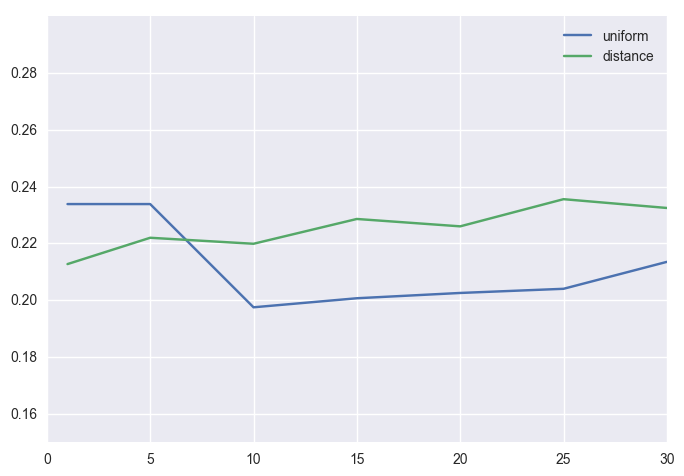

In [17]:
##KNeighborsRegressor
##ripe for feature reduction
n = [1,5,10,15,20,25,30]
w = ["uniform", "distance"]

start = time.time()
knr_params = {"n_neighbors": n,
             "weights": w}
gs4 = GridSearchCV(knr_model, knr_params, scoring = simple_rmse)
gs4.fit(test,y)
end = time.time()
print end-start
print gs4.best_estimator_
print gs4.best_score_
print gs4.best_params_

for a,val in enumerate(w):
    plt.plot(n,-gs4.cv_results_['mean_test_score'][len(n)*a:len(n)*(a+1)], label=val)
    plt.legend()
plt.ylim((.15,.3))
plt.show;


mean: -0.0113
standard deviation: 0.2068


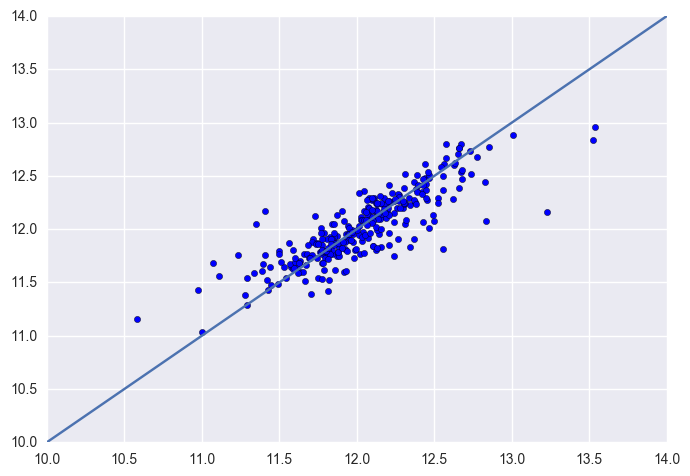

In [18]:
knr_best = KNR(n_neighbors = gs4.best_params_['n_neighbors'], weights = gs4.best_params_['weights'])
plot_it(knr_best)

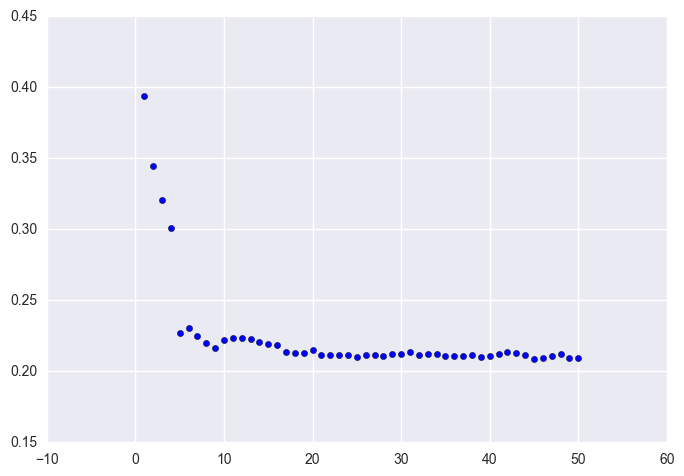

In [19]:
plot_pca(knr_best, 50)

7.78900003433
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
-0.234517276797
{'max_features': 'auto', 'criterion': 'mse'}
[-0.23451728 -0.23631206 -0.28792585 -0.28325273 -0.24901462 -0.24014113
 -0.24100862 -0.24404724 -0.27355095 -0.26588081 -0.25407714 -0.24741437]
mean: -0.0003
standard deviation: 0.2200


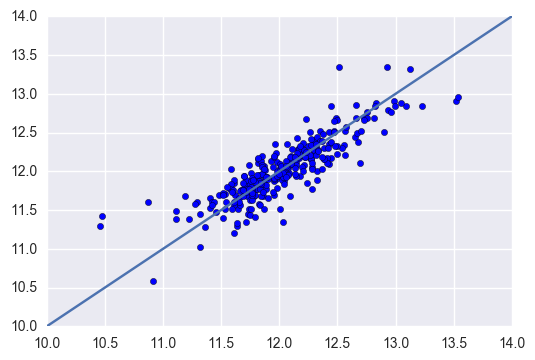

In [42]:
##DecisionTreeRegressor
start = time.time()
dtr_params = {"max_features": ["auto",None, 10, 30, 50, 100],
             "criterion": ["mse", "mae"]}
gs5 = GridSearchCV(dtr_model, dtr_params, scoring = simple_rmse)
gs5.fit(x,y)
end = time.time()
print end-start
print gs5.best_estimator_
print gs5.best_score_
print gs5.best_params_
print gs5.cv_results_['mean_test_score']

dtr_best = DTR(max_features = gs5.best_params_['max_features'], criterion = 'mse')
plot_it(dtr_best)

In [ ]:
##linear svr
##feature reduction
start = time.time()
c = [.001,.01,.1,1,10]
lsvr_params = {"C": c}
gs6 = GridSearchCV(lsvr_model, lsvr_params, scoring = simple_rmse)
gs6.fit(x,y)
end = time.time()
print end-start
print gs6.best_estimator_
print gs6.best_score_
print gs6.best_params_

plt.plot(c, gs6.cv_results_['mean_test_score'])


In [44]:
lsvr_best = SVR(kernel = 'linear', c = gs6.best_params_['C'])
plot_it(lsvr_best)

952.128000021
SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-0.144755001239
{'C': 10, 'degree': 1}


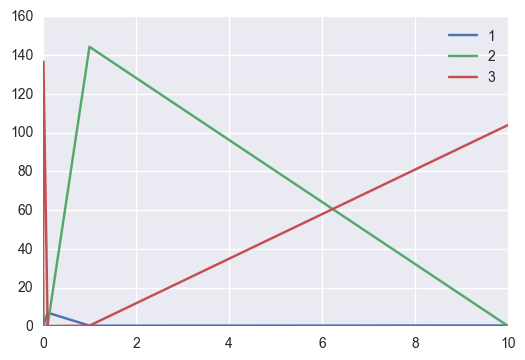

In [96]:
##poly svr
##feature reduction
c = [.001,.01,.1,1,10]
d = [1,2,3]
start = time.time()
psvr_params = {"C": c,
              "degree": d}
gs7 = GridSearchCV(psvr_model, psvr_params, scoring = simple_rmse)
gs7.fit(x,y)
end = time.time()
print end-start
print gs7.best_estimator_
print gs7.best_score_
print gs7.best_params_

for a,val in enumerate(d):
    plt.plot(c,-gs7.cv_results_['mean_test_score'][len(c)*a:len(c)*(a+1)], label=val)
    plt.legend()
plt.show;


mean: 0.0113
standard deviation: 0.1156


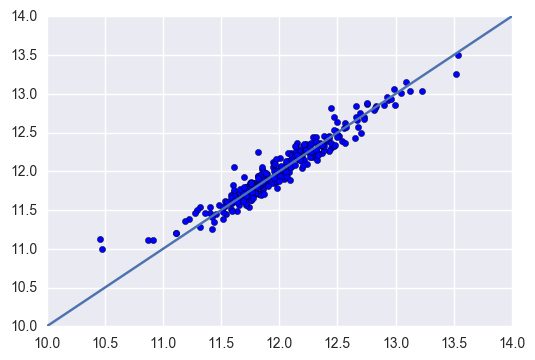

In [95]:
psvr_best = SVR(kernel = 'poly', C = gs7.best_params_['C'], degree = gs7.best_params_['degree'])
plot_it(psvr_best)

11.9500000477
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-0.18393145541
{'C': 5}


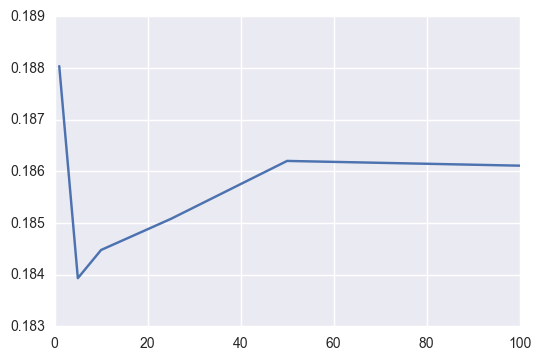

In [75]:
##rbf svr
##feature reduction
c = [1,5,10,25,50,100]
start = time.time()
rsvr_params = {"C": c}
gs8 = GridSearchCV(rsvr_model, rsvr_params, scoring = simple_rmse)
gs8.fit(x,y)
end = time.time()
print end-start
print gs8.best_estimator_
print gs8.best_score_
print gs8.best_params_

plt.plot(c, -gs8.cv_results_['mean_test_score'])


mean: -0.0034
standard deviation: 0.1941


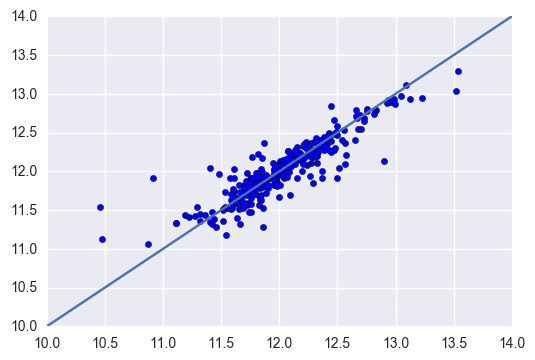

In [77]:
rsvr_best = SVR(kernel = 'rbf', C = gs8.best_params_['C'])
plot_it(rsvr_best)

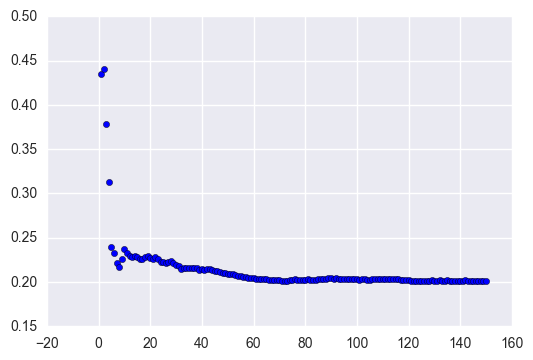

In [92]:
plot_pca(rsvr_best, 150)

1.74699997902
PassiveAggressiveRegressor(C=0.5, epsilon=0.1, fit_intercept=True,
              loss='epsilon_insensitive', n_iter=5, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
-0.312028413571
{'C': 0.5}
[-0.43129446 -0.71156852 -0.8072485  -0.51947525 -0.31202841 -0.36281068]


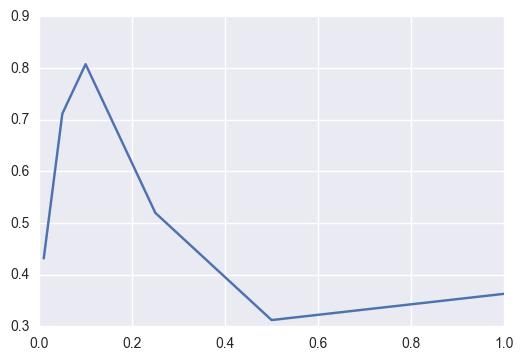

In [49]:
##passive aggressive regression
##feature reduction
c = [.01,.05, .1,.25,.5,1]
start = time.time()
par_params = {"C": c}
gs9 = GridSearchCV(par_model, par_params, scoring = simple_rmse)
gs9.fit(x,y)
end = time.time()
print end-start
print gs9.best_estimator_
print gs9.best_score_
print gs9.best_params_
print gs9.cv_results_['mean_test_score']

plt.plot(c, -gs9.cv_results_['mean_test_score']);


mean: -0.0987
standard deviation: 0.4052


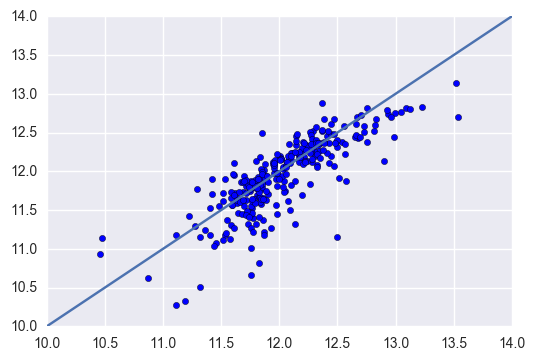

In [50]:
par_best = PAR(C = gs9.best_params_['C'])
plot_it(par_best)

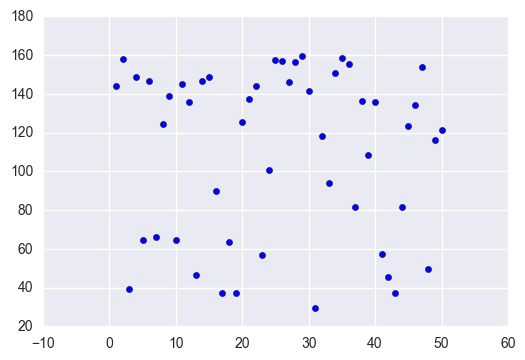

In [90]:
plot_pca(par_best, 50)

3.63499999046
KernelRidge(alpha=0.5, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)
-0.152267603203
{'alpha': 0.5}


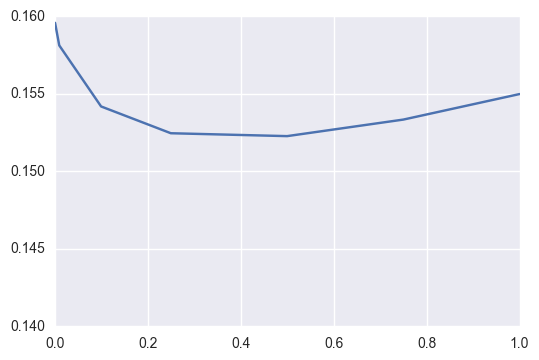

In [68]:
##linear kernel ridge
##feature reduction
a = [.001,.01,.1, .25, .5, .75, 1]
start = time.time()
lkr_params = {"alpha": a}
gs10 = GridSearchCV(lkr_model, lkr_params, scoring = simple_rmse)
gs10.fit(x,y)
end = time.time()
print end-start
print gs10.best_estimator_
print gs10.best_score_
print gs10.best_params_

plt.plot(a, -gs10.cv_results_['mean_test_score'])
plt.ylim((.14,.16));


mean: 0.0035
standard deviation: 0.1289


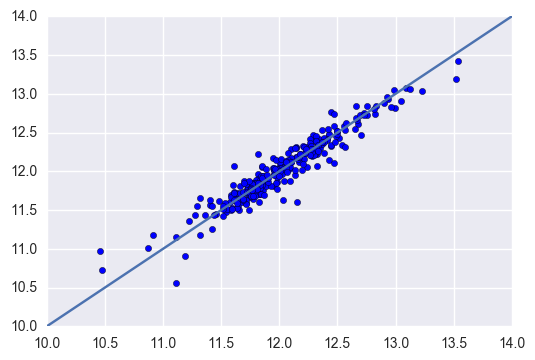

In [69]:
lkr_best = KR(kernel = 'linear', alpha = gs10.best_params_['alpha'])
plot_it(lkr_best)

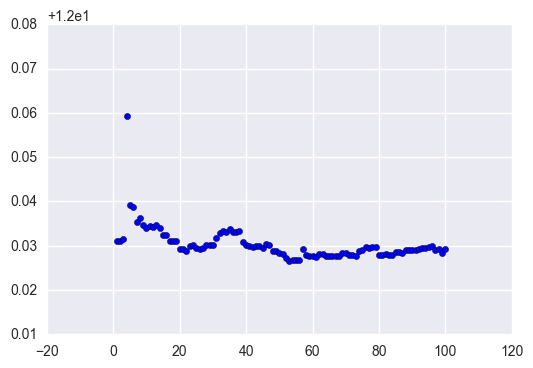

In [87]:
plot_pca(lkr_best, 100)

11.5579998493
KernelRidge(alpha=0.01, coef0=1, degree=1, gamma=None, kernel='poly',
      kernel_params=None)
-0.140693140853
{'alpha': 0.01, 'degree': 1}


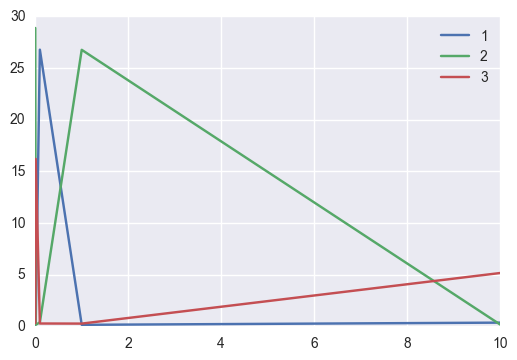

In [57]:
##poly kernel ridge
##feature reduction
a = [.001,.01,.1,1,10]
d = [1,2,3]
start = time.time()
pkr_params = {"alpha": a,
              "degree": d}
gs11 = GridSearchCV(pkr_model, pkr_params, scoring = simple_rmse)
gs11.fit(x,y)
end = time.time()
print end-start
print gs11.best_estimator_
print gs11.best_score_
print gs11.best_params_

for b,val in enumerate(d):
    plt.plot(a,-gs11.cv_results_['mean_test_score'][len(a)*b:len(a)*(b+1)], label=val)
    plt.legend()
plt.show;


mean: 0.0047
standard deviation: 0.1212


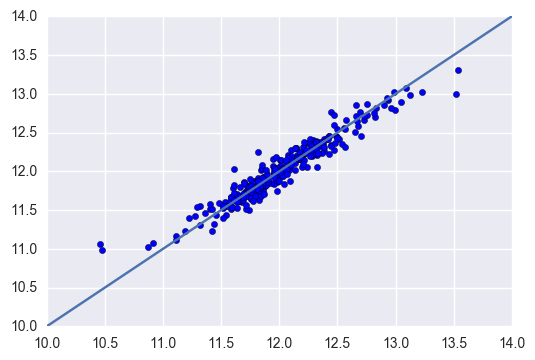

In [54]:
pkr_best = KR(kernel = 'poly', alpha = gs11.best_params_['alpha'], degree = gs11.best_params_['degree'])
plot_it(pkr_best)

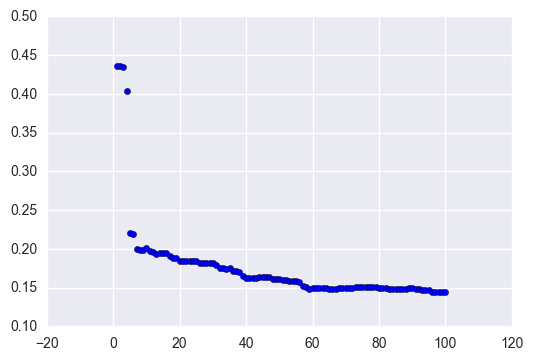

In [85]:
plot_pca(pkr_best, 100)

11.2839999199
KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001, kernel='rbf',
      kernel_params=None)
-1.8954210246
{'alpha': 0.001, 'gamma': 0.001}


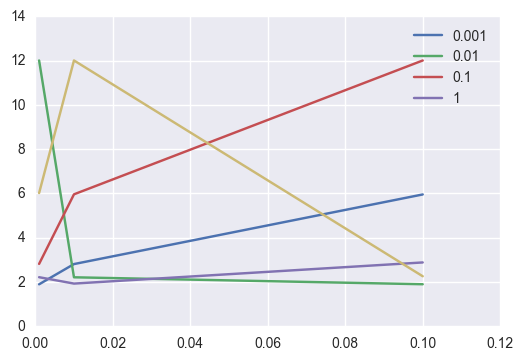

In [100]:
##rbf kernel ridge
##feature reduction
a = [.001,.01,.1]
gamma = [.001, .01, .1, 1, None]
start = time.time()
rkr_params = {"alpha": a,
             "gamma": gamma}
gs12 = GridSearchCV(rkr_model, rkr_params, scoring = simple_rmse)
gs12.fit(x,y)
end = time.time()
print end-start
print gs12.best_estimator_
print gs12.best_score_
print gs12.best_params_

for b,val in enumerate(gamma):
    plt.plot(a,-gs12.cv_results_['mean_test_score'][len(a)*b:len(a)*(b+1)], label=val)
    plt.legend()
plt.show;
              

mean: -0.5677
standard deviation: 2.2892


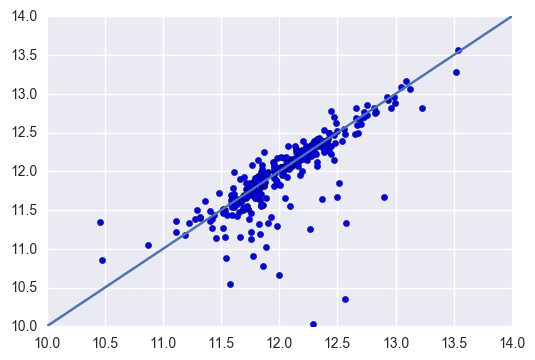

In [101]:
rkr_best = KR(kernel = 'rbf', alpha = gs12.best_params_['alpha'])
plot_it(rkr_best)

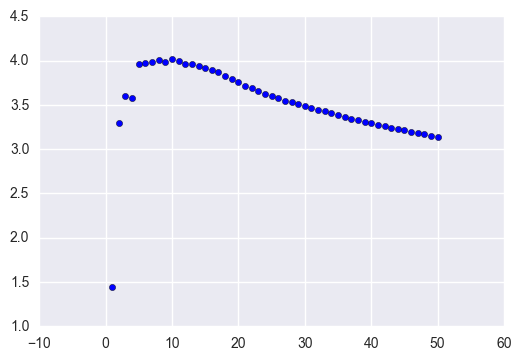

In [102]:
plot_pca(rkr_best, 50)

[ 0.17495662  0.19834473  0.18980108  0.17325657  0.16488156]
mean: -0.0090
standard deviation: 0.1816
156.309000015


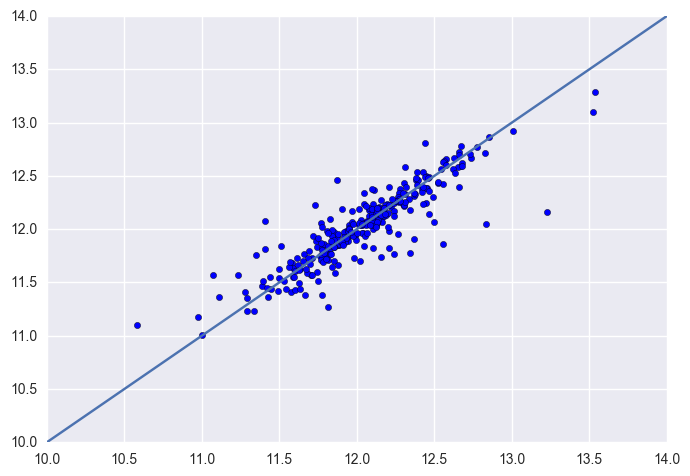

In [4]:
##GaussianProcessRegressor
##feature reduction
from sklearn.gaussian_process.kernels import RationalQuadratic


kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
start = time.time()
# Specify Gaussian Process
gp = GPR(kernel=kernel)
print rmse_cv(gp, x, y)
plot_it(gp)
    
end = time.time()
print end-start


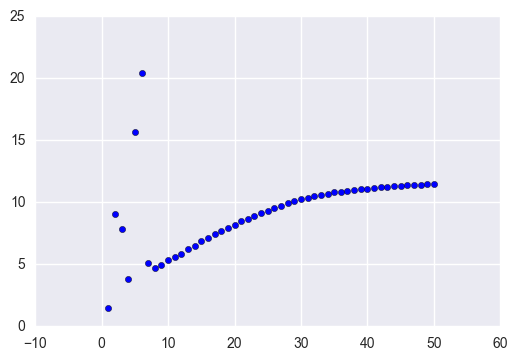

In [79]:
plot_pca(gp, 50)